
# <center>Python课程实践--深度学习</center>

## 课程内容

* 1.循环神经网络RNN
* 2.长短期记忆网络LSTM
* 3.IMDB电影评论分类

## 1.循环神经网络RNN

### 1.1 循环神经网络简介

CNN等传统神经网络的局限在于：将固定大小的向量作为输入（比如一张图片），然后输出一个固定大小的向量（比如不同分类的概率）。不仅如此，CNN还按照固定的计算步骤（比如模型中层的数量）来实现这样的输入输出。这样的神经网络没有持久性：假设你希望对电影中每一帧的事件类型进行分类，传统的神经网络就没有办法使用电影中先前的事件推断后续的事件。

RNN 解决了这个问题。RNN 是包含循环的网络，允许信息的持久化。在自然语言处理(NLP)领域，RNN已经可以做语音识别、机器翻译、生成手写字符，以及构建强大的语言模型 (Sutskever et al.)，(Graves)，(Mikolov et al.)（字符级别和单词级别的都有。在机器视觉领域，RNN也非常流行。包括帧级别的视频分类，图像描述，视频描述以及基于图像的Q&A等等。

#### RNN结构

神经网络的模块A正在读取某个输入xt，并输出一个值ht，循环可以使得信息从当前步传递到下一步，将这个循环展开，如下所示。链式的特征揭示了 RNN 本质上是与序列和列表相关的，它们是对于这类数据的最自然的神经网络架构。

![image](images/2.png)

#### 长期依赖问题

RNN 的关键点之一就是他们可以用来连接先前的信息到当前的任务上，例如使用过去的视频段来推测对当前段的理解。如果 RNN 可以做到这个，他们就变得非常有用。但是真的可以么？答案是，还有很多依赖因素。有时候，我们仅仅需要知道先前的信息来执行当前的任务。例如，我们有一个语言模型用来基于先前的词来预测下一个词。如果我们试着预测 “the clouds are in the sky” 最后的词，我们并不需要任何其他的上下文 —— 因此下一个词很显然就应该是 sky。在这样的场景中，相关的信息和预测的词位置之间的间隔是非常小的，RNN 可以学会使用先前的信息。

![image](images/3.png)

但是同样会有一些更加复杂的场景。假设我们试着去预测“I grew up in France... I speak fluent French”最后的词。当前的信息建议下一个词可能是一种语言的名字，但是如果我们需要弄清楚是什么语言，我们是需要先前提到的离当前位置很远的 France 的上下文的。这说明相关信息和当前预测位置之间的间隔就肯定变得相当的大。不幸的是，在这个间隔不断增大时，RNN 会丧失学习到连接如此远的信息的能力。

![image](images/4.png)

在理论上，RNN 绝对可以处理这样的长期依赖问题。人们可以仔细挑选参数来解决这类问题中的最初级形式，但在实践中，RNN 肯定不能够成功学习到这些知识。Bengio, et al. (1994)等人对该问题进行了深入的研究，他们发现一些使训练 RNN 变得非常困难的相当根本的原因。然而，幸运的是，LSTM 并没有这个问题！


### 1.2 理解循环神经网络

In [1]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

Using TensorFlow backend.


In [2]:
#只返回最后一个时间步的输出

#构建一个序列的网络结构
model = Sequential()
model.add(Embedding(1000, 32)) #添加一层字嵌入式
model.add(SimpleRNN(32)) #增加RNN
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


In [3]:
#返回完整的状态序列
model =Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
#将多个循环层逐个堆叠---需要所有中间层都返回完整的输出序列
model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 40,320
Trainable params: 40,320
Non-trainable params: 0
_________________________________________________________________


### 1.3 在IMDB数据上应用SimpleRNN

IMDB数据集包含来自互联网的50000条严重两极分化的评论，该数据被分为用于训练的25000条评论和用于测试的25000条评论，训练集和测试集都包含50%的正面评价和50%的负面评价。该数据集已经经过预处理：评论（单词序列）已经被转换为整数序列，其中每个整数代表字典中的某个单词。


In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 1000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train_sequences')
print(len(input_test), 'test_sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train.shape: ',input_train.shape )
print('input_test.shape: ', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 17s 1us/step
25000 train_sequences
25000 test_sequences
Pad sequences (samples x time)
input_train.shape:  (25000, 500)
input_test.shape:  (25000, 500)


In [6]:
input_train
y_train
#数据集已经对单词进行了编码

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [7]:
from keras.layers import Dense   #Dense就是常用的全连接层

#构造序列的网络结构
model = Sequential()

#Embedding层只能作为模型的第一层
#input_dim：大或等于0的整数，字典长度，即输入数据最大下标+1
#output_dim：大于0的整数，代表全连接嵌入的维度
model.add(Embedding(max_features, 32))

model.add(SimpleRNN(32)) #必须也是32位
model.add(Dense(1, activation='sigmoid')) #最后网络输出为 1个 变量，  用于分类  Sigmoid函数常被用作神经网络的阈值函数，将变量映射到0,1之间

#编译模型
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

#训练模型
history = model.fit(input_train, y_train,
                   epochs=5,
                   batch_size=128,
                   validation_split=0.2)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 19s 939us/step - loss: 0.6366 - acc: 0.6236 - val_loss: 0.5501 - val_acc: 0.7384
Epoch 2/5
20000/20000 [==============================] - 20s 995us/step - loss: 0.4727 - acc: 0.7836 - val_loss: 0.4131 - val_acc: 0.8232
Epoch 3/5
20000/20000 [==============================] - 20s 1ms/step - loss: 0.4276 - acc: 0.8108 - val_loss: 0.4322 - val_acc: 0.8038
Epoch 4/5
20000/20000 [==============================] - 21s 1ms/step - loss: 0.3847 - acc: 0.8374 - val_loss: 0.4426 - val_acc: 0.8174
Epoch 5/5
20000/20000 [==============================] - 20s 993us/step - loss: 0.3532 - acc: 0.8512 - val_loss: 0.4667 - val_acc: 0.8078


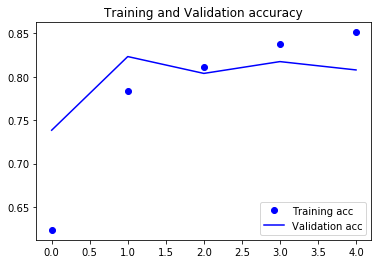

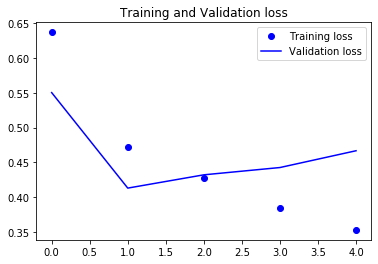

In [8]:
#绘制训练的学习曲线

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [9]:
#验证模型
#Returns the loss value & metrics values for the model in test mode

results = model.evaluate(input_test, y_test)
print(results)

25000/25000 [==============================] - 17s 690us/step
[0.4595277501296997, 0.8057600259780884]


## 2 长短期记忆网络LSTM

### 2.1 长短期记忆网络简介

 Long Short Term 网络—— 一般就叫做 LSTM，是一种 RNN 特殊的类型，可以学习长期依赖信息。LSTM 由Hochreiter & Schmidhuber (1997)提出，并在近期被Alex Graves进行了改良和推广。在很多问题，LSTM 都取得相当巨大的成功，并得到了广泛的使用。LSTM 通过刻意的设计来避免长期依赖问题。记住长期的信息在实践中是 LSTM 的默认行为，而非需要付出很大代价才能获得的能力！

所有 RNN 都具有一种重复神经网络模块的链式的形式。在标准的 RNN 中，这个重复的模块只有一个非常简单的结构，例如一个 tanh 层。

![image](images/5.png)

LSTM 同样是这样的结构，但是重复的模块拥有一个不同的结构。不同于 单一神经网络层，这里是有四个，以一种非常特殊的方式进行交互。

![image](images/6.png)

#### LSTM网络详解

下面对LSTM网络进行详细说明，首先说明一下图中使用的图标，如下：

![image](images/7.png)

在上面的图例中，每一条黑线传输着一整个向量，从一个节点的输出到其他节点的输入。粉色的圈代表按位 pointwise 的操作，诸如向量的和，而黄色的矩阵就是学习到的神经网络层。合在一起的线表示向量的连接，分开的线表示内容被复制，然后分发到不同的位置。

LSTM 的关键就是细胞状态cell state，水平线在图上方贯穿运行，也就是贯穿每个重复结构的上面这条flow。细胞状态类似于传送带，直接在整个链上运行，只有一些少量的线性交互。信息在上面流传保持不变会很容易。这条flow其实就承载着之前所有状态的信息，每当flow流经一个重复结构A的时候，都会有相应的操作来决定舍弃什么旧的信息以及添加什么新的信息。

![image](images/8.png)

LSTM 有通过精心设计对信息增减进行控制的结构，称作为“门”。门是一种让信息选择式通过的方法。他们包含一个 sigmoid 神经网络层和一个按位的乘法操作。Sigmoid 层输出 0 到 1 之间的数值，描述每个部分有多少量可以通过。0 代表“不许任何量通过”，1 就指“允许任意量通过”！

![image](images/9.png)

LSTM 拥有三个门，来保护和控制细胞状态，分别是遗忘门 (forget gate)、输入门 (input gate)、输出门 (output gate)。下面对这三个门进行详细讲解

#### 遗忘门 (forget gate)

遗忘门决定了要从cell state中舍弃什么信息。其通过输入上一状态的输出ht-1、当前状态输入信息Xt到一个Sigmoid函数中，产生一个介于0到1之间的数值，与cell state相乘之后来确定舍弃（保留）多少信息。0 表示“完全舍弃”，1 表示“完全保留”。

![image](images/10.png)

上式中，<img src="https://latex.codecogs.com/svg.latex?\dpi{300}&space;W_{f}" title="W_{f}" />可以写为：<img src="https://latex.codecogs.com/svg.latex?\dpi{300}&space;[W_{f}]\begin{bmatrix}&space;h_{t-1}\\&space;x_{t}&space;\end{bmatrix}=\begin{bmatrix}&space;W_{fh}&space;&&space;W_{fx}&space;\end{bmatrix}\begin{bmatrix}&space;h_{t-1}\\&space;x_{t}&space;\end{bmatrix}=W_{fh}h_{t-1}&plus;W_{fx}x_{t}" title="[W_{f}]\begin{bmatrix} h_{t-1}\\ x_{t} \end{bmatrix}=\begin{bmatrix} W_{fh} & W_{fx} \end{bmatrix}\begin{bmatrix} h_{t-1}\\ x_{t} \end{bmatrix}=W_{fh}h_{t-1}+W_{fx}x_{t}" />


#### 输入门 (input gate)

输入门决定了要往cell state中保存什么新的信息。其通过输入上一状态的输出、当前状态输入信息到一个Sigmoid函数中，产生一个介于0到1之间的数值来确定我们需要保留多少的新信息。同时，一个tanh层会通过上一状态的输出、当前状态输入信息来得到一个将要加入到cell state中的“候选新信息”。

![image](images/11.png)

现在计算当前时刻的单元状态。它是由上一次的单元状态按元素乘以遗忘门，丢弃掉我们确定需要丢弃的信息；然后把当前输入的单元状态按元素乘以输入门，将两个积加和，这就是新的候选值：

<img src="https://latex.codecogs.com/svg.latex?\dpi{300}&space;C_{t}=f_{t}*C_{t-1}&plus;i_{t}*\widetilde{C_{t}}" title="C_{t}=f_{t}*C_{t-1}+i_{t}*\widetilde{C_{t}}" />

![image](images/12.png)

#### 输出门 (output gate)

输出门决定了要从cell state中输出什么信息。这个输出将会基于我们的细胞状态，但是也是一个过滤后的版本，会先有一个Sigmoid函数产生一个介于0到1之间的数值来确定我们需要输出多少cell state中的信息。cell state的信息再与相乘时首先会经过一个tanh层进行“激活”（非线性变换）。得到的就是这个LSTM block的输出信息。

![image](images/13.png)

### 2.2 理解长短期记忆网络

循环神经网络(RNN)的变种是长短期模型网络(LSTM)。它使用广泛，因为它的架构克服了困扰着所有周期性的神经网络梯度消失和梯度爆炸的问题，允许创建非常大的、非常深的网络。

#### 学习字母表

学习字母表是一个简单的序列预测问题。也就是说，根据字母表的字母，可以预测字母表的下一个字母。

这是一个简单的序列预测问题，一旦被理解，就可以被推广到其他的序列预测问题，如时间序列预测和序列分类。

![](images/LSTM.jpg)

#### 单字符——单字符的映射的简单LSTM
学习如何根据一个字符的上下文来预测字母表中的下一个字符。

定义一个LSTM网络，它有32个单元，一个输出层，其中有一个softmax的激活函数来进行预测。由于这是一个多类分类问题，所以我们可以使用在Keras中使用对数损失函数(称为“分类交叉熵”(categorical_crossentropy))，并使用ADAM优化函数对网络进行优化。

In [10]:
# Naive LSTM to learn one-char to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

In [11]:
# 对随机数生成器选定随机数种子，以确保每次执行代码时结果都是相同的。
numpy.random.seed(7)
# define the raw dataset
# 为了便于阅读，我们用大写字母来定义字母表。
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
# 神经网络是对数字建模，因此我们需要将字母表中的字母映射到整数值（把字母映射为数字）。我们可以很容易地通过创建字母索引的字典(map)到字符。
# 我们还可以创建一个反向查找，以便将预测转换回字符，以便稍后使用。
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# prepare the dataset of input to output pairs encoded as integers
# 造这样一个数据集，用一个字母，来预测下一个字母是什么
seq_length = 1
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
	seq_in = alphabet[i:i + seq_length]
	seq_out = alphabet[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
	print(seq_in, '->', seq_out)

A -> B
B -> C
C -> D
D -> E
E -> F
F -> G
G -> H
H -> I
I -> J
J -> K
K -> L
L -> M
M -> N
N -> O
O -> P
P -> Q
Q -> R
R -> S
S -> T
T -> U
U -> V
V -> W
W -> X
X -> Y
Y -> Z


In [12]:
# reshape X to be [samples, time steps, features]
# 需要将NumPy数组重新构造为LSTM网络所期望的格式，即[samples示例, time steps时间步数, features特征]。
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

In [13]:
X

array([[[ 0]],

       [[ 1]],

       [[ 2]],

       [[ 3]],

       [[ 4]],

       [[ 5]],

       [[ 6]],

       [[ 7]],

       [[ 8]],

       [[ 9]],

       [[10]],

       [[11]],

       [[12]],

       [[13]],

       [[14]],

       [[15]],

       [[16]],

       [[17]],

       [[18]],

       [[19]],

       [[20]],

       [[21]],

       [[22]],

       [[23]],

       [[24]]])

In [14]:
X.shape

(25, 1, 1)

In [15]:
# normalize
# 需要把我们的整数值归一化到0～1的区间上，这是LSTM网络使用的s形激活函数（sigmoid）的范围
X = X / float(len(alphabet))

In [16]:
# one hot encode the output variable
# 把这个问题看作是一个序列分类任务，其中26个字母代表一个不同的类。
# 用keras的内置的 to_categorical()函数把输出output(y)进行 one－hot编码(one-hot指n维单位向量a=(0,…,0,1,0,…,0))作为输出层的结果。
y = np_utils.to_categorical(dataY)

In [17]:
y

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [18]:
# create and fit the model
# 定义一个LSTM网络，它有32个单元，一个输出层，其中有一个softmax的激活函数来进行预测。
# 由于这是一个多类分类问题，所以我们可以使用在Keras中使用对数损失函数(称为“分类交叉熵”(categorical_crossentropy))，
# 并使用ADAM优化函数对网络进行优化。
# 该模型以500批次(epochs)，每批次数据输入大小(batch)为1的形式训练
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
 - 0s - loss: 3.2661 - accuracy: 0.0000e+00
Epoch 2/500
 - 0s - loss: 3.2582 - accuracy: 0.0000e+00
Epoch 3/500
 - 0s - loss: 3.2551 - accuracy: 0.0400
Epoch 4/500
 - 0s - loss: 3.2524 - accuracy: 0.0400
Epoch 5/500
 - 0s - loss: 3.2495 - accuracy: 0.0400
Epoch 6/500
 - 0s - loss: 3.2470 - accuracy: 0.0400
Epoch 7/500
 - 0s - loss: 3.2438 - accuracy: 0.0400
Epoch 8/500
 - 0s - loss: 3.2410 - accuracy: 0.0400
Epoch 9/500
 - 0s - loss: 3.2376 - accuracy: 0.0400
Epoch 10/500
 - 0s - loss: 3.2345 - accuracy: 0.0400
Epoch 11/500
 - 0s - loss: 3.2308 - accuracy: 0.0400
Epoch 12/500
 - 0s - loss: 3.2271 - accuracy: 0.0400
Epoch 13/500
 - 0s - loss: 3.2230 - accuracy: 0.0400
Epoch 14/500
 - 0s - loss: 3.2195 - accuracy: 0.0400
Epoch 15/500
 - 0s - loss: 3.2150 - accuracy: 0.0400
Epoch 16/500
 - 0s - loss: 3.2104 - accuracy: 0.0400
Epoch 17/500
 - 0s - loss: 3.2050 - accuracy: 0.0400
Epoch 18/500
 - 0s - loss: 3.1998 - accuracy: 0.0400
Epoch 19/500
 - 0s - loss: 3.1947 - accuracy: 0

Epoch 155/500
 - 0s - loss: 2.2736 - accuracy: 0.2400
Epoch 156/500
 - 0s - loss: 2.2729 - accuracy: 0.2000
Epoch 157/500
 - 0s - loss: 2.2681 - accuracy: 0.2400
Epoch 158/500
 - 0s - loss: 2.2640 - accuracy: 0.2400
Epoch 159/500
 - 0s - loss: 2.2635 - accuracy: 0.2800
Epoch 160/500
 - 0s - loss: 2.2596 - accuracy: 0.2400
Epoch 161/500
 - 0s - loss: 2.2551 - accuracy: 0.2400
Epoch 162/500
 - 0s - loss: 2.2534 - accuracy: 0.2400
Epoch 163/500
 - 0s - loss: 2.2498 - accuracy: 0.3200
Epoch 164/500
 - 0s - loss: 2.2469 - accuracy: 0.2400
Epoch 165/500
 - 0s - loss: 2.2428 - accuracy: 0.2400
Epoch 166/500
 - 0s - loss: 2.2394 - accuracy: 0.2400
Epoch 167/500
 - 0s - loss: 2.2369 - accuracy: 0.2400
Epoch 168/500
 - 0s - loss: 2.2337 - accuracy: 0.2000
Epoch 169/500
 - 0s - loss: 2.2320 - accuracy: 0.2400
Epoch 170/500
 - 0s - loss: 2.2282 - accuracy: 0.2400
Epoch 171/500
 - 0s - loss: 2.2261 - accuracy: 0.2800
Epoch 172/500
 - 0s - loss: 2.2220 - accuracy: 0.3200
Epoch 173/500
 - 0s - loss: 

Epoch 307/500
 - 0s - loss: 1.9321 - accuracy: 0.5200
Epoch 308/500
 - 0s - loss: 1.9298 - accuracy: 0.5200
Epoch 309/500
 - 0s - loss: 1.9274 - accuracy: 0.5600
Epoch 310/500
 - 0s - loss: 1.9272 - accuracy: 0.5600
Epoch 311/500
 - 0s - loss: 1.9252 - accuracy: 0.6000
Epoch 312/500
 - 0s - loss: 1.9249 - accuracy: 0.5200
Epoch 313/500
 - 0s - loss: 1.9216 - accuracy: 0.6000
Epoch 314/500
 - 0s - loss: 1.9210 - accuracy: 0.4800
Epoch 315/500
 - 0s - loss: 1.9183 - accuracy: 0.5600
Epoch 316/500
 - 0s - loss: 1.9170 - accuracy: 0.6000
Epoch 317/500
 - 0s - loss: 1.9156 - accuracy: 0.5600
Epoch 318/500
 - 0s - loss: 1.9133 - accuracy: 0.6800
Epoch 319/500
 - 0s - loss: 1.9114 - accuracy: 0.6400
Epoch 320/500
 - 0s - loss: 1.9106 - accuracy: 0.5600
Epoch 321/500
 - 0s - loss: 1.9094 - accuracy: 0.5200
Epoch 322/500
 - 0s - loss: 1.9066 - accuracy: 0.6000
Epoch 323/500
 - 0s - loss: 1.9056 - accuracy: 0.5600
Epoch 324/500
 - 0s - loss: 1.9040 - accuracy: 0.5600
Epoch 325/500
 - 0s - loss: 

Epoch 459/500
 - 0s - loss: 1.7355 - accuracy: 0.6800
Epoch 460/500
 - 0s - loss: 1.7324 - accuracy: 0.7600
Epoch 461/500
 - 0s - loss: 1.7316 - accuracy: 0.7200
Epoch 462/500
 - 0s - loss: 1.7302 - accuracy: 0.7600
Epoch 463/500
 - 0s - loss: 1.7296 - accuracy: 0.7600
Epoch 464/500
 - 0s - loss: 1.7279 - accuracy: 0.7200
Epoch 465/500
 - 0s - loss: 1.7297 - accuracy: 0.7600
Epoch 466/500
 - 0s - loss: 1.7273 - accuracy: 0.6800
Epoch 467/500
 - 0s - loss: 1.7244 - accuracy: 0.7600
Epoch 468/500
 - 0s - loss: 1.7240 - accuracy: 0.8000
Epoch 469/500
 - 0s - loss: 1.7233 - accuracy: 0.8000
Epoch 470/500
 - 0s - loss: 1.7214 - accuracy: 0.6800
Epoch 471/500
 - 0s - loss: 1.7234 - accuracy: 0.7600
Epoch 472/500
 - 0s - loss: 1.7212 - accuracy: 0.8000
Epoch 473/500
 - 0s - loss: 1.7185 - accuracy: 0.6800
Epoch 474/500
 - 0s - loss: 1.7202 - accuracy: 0.7200
Epoch 475/500
 - 0s - loss: 1.7172 - accuracy: 0.7600
Epoch 476/500
 - 0s - loss: 1.7203 - accuracy: 0.7200
Epoch 477/500
 - 0s - loss: 

In [19]:
# summarize performance of the model
# 对整个训练集的性能进行评估和总结
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 88.00%


In [20]:
# demonstrate some model predictions
# 通过网络重新运行训练数据，并生成预测，将输入和输出对转换回原来的字符格式，以获得关于网络如何了解问题的视觉效果。
for pattern in dataX:
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print(seq_in, "->", result)

['A'] -> B
['B'] -> B
['C'] -> D
['D'] -> E
['E'] -> F
['F'] -> G
['G'] -> H
['H'] -> I
['I'] -> J
['J'] -> K
['K'] -> L
['L'] -> M
['M'] -> N
['N'] -> O
['O'] -> P
['P'] -> Q
['Q'] -> R
['R'] -> S
['S'] -> T
['T'] -> U
['U'] -> V
['V'] -> W
['W'] -> Y
['X'] -> Z
['Y'] -> Z


原因是可怜的lstm单元根本没有可以利用的上下文章信息。 
每个输入输出模式都以随机的顺序显示在网络中，并且网络的状态在每个模式之后被重置(每个批处理的每个批次包含一个模式)。

这是对LSTM网络架构的滥用，因为我们把它当作了一个标准的多层感知器。

#### 三字符特征——单字符的映射的简单LSTM

在多层感知器中添加更多上下文最流行的方法是特征窗口方法(Feature Window method)。

即序列中的前面步骤的输出被作为附加的输入特性提供给网络。我们可以用相同的技巧，为LSTM网络提供更多的上下文。

**将序列长度从1增加到3**

In [21]:
# Naive LSTM to learn three-char window to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
# fix random seed for reproducibility
numpy.random.seed(7)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [22]:
# prepare the dataset of input to output pairs encoded as integers
# 在这里，我们将序列长度从1增加到3，例如: 我们把输入从一个字符升到三个字符。
seq_length = 3
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
	seq_in = alphabet[i:i + seq_length]
	seq_out = alphabet[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
	print(seq_in, '->', seq_out)
    
# reshape X to be [samples, time steps, features]
# 将序列中的每个元素作为网络的一个新输入特性提供给它。这需要修改输入序列在数据准备步骤中的reshape:
X = numpy.reshape(dataX, (len(dataX), 1, seq_length))
# normalize
X = X / float(len(alphabet))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# create and fit the model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, batch_size=1, verbose=2)

ABC -> D
BCD -> E
CDE -> F
DEF -> G
EFG -> H
FGH -> I
GHI -> J
HIJ -> K
IJK -> L
JKL -> M
KLM -> N
LMN -> O
MNO -> P
NOP -> Q
OPQ -> R
PQR -> S
QRS -> T
RST -> U
STU -> V
TUV -> W
UVW -> X
VWX -> Y
WXY -> Z
Epoch 1/500
 - 0s - loss: 3.2741 - accuracy: 0.0000e+00
Epoch 2/500
 - 0s - loss: 3.2612 - accuracy: 0.0000e+00
Epoch 3/500
 - 0s - loss: 3.2538 - accuracy: 0.0435
Epoch 4/500
 - 0s - loss: 3.2474 - accuracy: 0.0435
Epoch 5/500
 - 0s - loss: 3.2410 - accuracy: 0.0435
Epoch 6/500
 - 0s - loss: 3.2340 - accuracy: 0.0435
Epoch 7/500
 - 0s - loss: 3.2279 - accuracy: 0.0435
Epoch 8/500
 - 0s - loss: 3.2213 - accuracy: 0.0435
Epoch 9/500
 - 0s - loss: 3.2139 - accuracy: 0.0435
Epoch 10/500
 - 0s - loss: 3.2070 - accuracy: 0.0435
Epoch 11/500
 - 0s - loss: 3.1994 - accuracy: 0.0435
Epoch 12/500
 - 0s - loss: 3.1916 - accuracy: 0.0435
Epoch 13/500
 - 0s - loss: 3.1839 - accuracy: 0.0435
Epoch 14/500
 - 0s - loss: 3.1748 - accuracy: 0.0435
Epoch 15/500
 - 0s - loss: 3.1663 - accuracy: 0.0435

Epoch 151/500
 - 0s - loss: 2.2457 - accuracy: 0.1739
Epoch 152/500
 - 0s - loss: 2.2424 - accuracy: 0.2174
Epoch 153/500
 - 0s - loss: 2.2370 - accuracy: 0.1304
Epoch 154/500
 - 0s - loss: 2.2346 - accuracy: 0.2174
Epoch 155/500
 - 0s - loss: 2.2300 - accuracy: 0.1739
Epoch 156/500
 - 0s - loss: 2.2278 - accuracy: 0.2174
Epoch 157/500
 - 0s - loss: 2.2237 - accuracy: 0.1739
Epoch 158/500
 - 0s - loss: 2.2192 - accuracy: 0.2174
Epoch 159/500
 - 0s - loss: 2.2159 - accuracy: 0.2609
Epoch 160/500
 - 0s - loss: 2.2129 - accuracy: 0.2174
Epoch 161/500
 - 0s - loss: 2.2109 - accuracy: 0.1739
Epoch 162/500
 - 0s - loss: 2.2061 - accuracy: 0.2609
Epoch 163/500
 - 0s - loss: 2.2012 - accuracy: 0.2609
Epoch 164/500
 - 0s - loss: 2.1991 - accuracy: 0.2174
Epoch 165/500
 - 0s - loss: 2.1960 - accuracy: 0.3043
Epoch 166/500
 - 0s - loss: 2.1931 - accuracy: 0.2174
Epoch 167/500
 - 0s - loss: 2.1890 - accuracy: 0.1739
Epoch 168/500
 - 0s - loss: 2.1858 - accuracy: 0.2609
Epoch 169/500
 - 0s - loss: 

Epoch 303/500
 - 0s - loss: 1.8703 - accuracy: 0.5652
Epoch 304/500
 - 0s - loss: 1.8710 - accuracy: 0.4783
Epoch 305/500
 - 0s - loss: 1.8684 - accuracy: 0.5652
Epoch 306/500
 - 0s - loss: 1.8637 - accuracy: 0.4783
Epoch 307/500
 - 0s - loss: 1.8627 - accuracy: 0.6087
Epoch 308/500
 - 0s - loss: 1.8614 - accuracy: 0.6522
Epoch 309/500
 - 0s - loss: 1.8609 - accuracy: 0.5652
Epoch 310/500
 - 0s - loss: 1.8578 - accuracy: 0.5652
Epoch 311/500
 - 0s - loss: 1.8565 - accuracy: 0.6522
Epoch 312/500
 - 0s - loss: 1.8527 - accuracy: 0.6087
Epoch 313/500
 - 0s - loss: 1.8527 - accuracy: 0.5217
Epoch 314/500
 - 0s - loss: 1.8508 - accuracy: 0.6087
Epoch 315/500
 - 0s - loss: 1.8496 - accuracy: 0.6087
Epoch 316/500
 - 0s - loss: 1.8481 - accuracy: 0.6087
Epoch 317/500
 - 0s - loss: 1.8448 - accuracy: 0.6087
Epoch 318/500
 - 0s - loss: 1.8442 - accuracy: 0.6087
Epoch 319/500
 - 0s - loss: 1.8421 - accuracy: 0.6957
Epoch 320/500
 - 0s - loss: 1.8415 - accuracy: 0.6087
Epoch 321/500
 - 0s - loss: 

Epoch 455/500
 - 0s - loss: 1.6597 - accuracy: 0.7391
Epoch 456/500
 - 0s - loss: 1.6633 - accuracy: 0.7826
Epoch 457/500
 - 0s - loss: 1.6567 - accuracy: 0.7391
Epoch 458/500
 - 0s - loss: 1.6598 - accuracy: 0.6957
Epoch 459/500
 - 0s - loss: 1.6575 - accuracy: 0.8261
Epoch 460/500
 - 0s - loss: 1.6587 - accuracy: 0.7391
Epoch 461/500
 - 0s - loss: 1.6570 - accuracy: 0.7826
Epoch 462/500
 - 0s - loss: 1.6546 - accuracy: 0.8261
Epoch 463/500
 - 0s - loss: 1.6519 - accuracy: 0.7391
Epoch 464/500
 - 0s - loss: 1.6493 - accuracy: 0.7391
Epoch 465/500
 - 0s - loss: 1.6507 - accuracy: 0.8261
Epoch 466/500
 - 0s - loss: 1.6528 - accuracy: 0.6957
Epoch 467/500
 - 0s - loss: 1.6484 - accuracy: 0.8261
Epoch 468/500
 - 0s - loss: 1.6474 - accuracy: 0.8696
Epoch 469/500
 - 0s - loss: 1.6454 - accuracy: 0.8261
Epoch 470/500
 - 0s - loss: 1.6441 - accuracy: 0.8261
Epoch 471/500
 - 0s - loss: 1.6454 - accuracy: 0.7826
Epoch 472/500
 - 0s - loss: 1.6414 - accuracy: 0.7391
Epoch 473/500
 - 0s - loss: 

In [23]:
# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))
# demonstrate some model predictions
for pattern in dataX:
	x = numpy.reshape(pattern, (1, 1, len(pattern)))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print(seq_in, "->", result)

Model Accuracy: 82.61%
['A', 'B', 'C'] -> D
['B', 'C', 'D'] -> E
['C', 'D', 'E'] -> F
['D', 'E', 'F'] -> G
['E', 'F', 'G'] -> H
['F', 'G', 'H'] -> I
['G', 'H', 'I'] -> J
['H', 'I', 'J'] -> K
['I', 'J', 'K'] -> L
['J', 'K', 'L'] -> M
['K', 'L', 'M'] -> N
['L', 'M', 'N'] -> O
['M', 'N', 'O'] -> P
['N', 'O', 'P'] -> Q
['O', 'P', 'Q'] -> R
['P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['R', 'S', 'T'] -> T
['S', 'T', 'U'] -> V
['T', 'U', 'V'] -> X
['U', 'V', 'W'] -> Z
['V', 'W', 'X'] -> Z
['W', 'X', 'Y'] -> Z


发现有了一点点的提升，但是这一点点的提升未必是真的，梯度下降算法本来就是具有随机性的。

也就是说我们再一次的错误使用了lstm循环神经网络。 
我们确实给了上下文，但是并不是合适的方式， 
实际上，字母序列ABC才是一个特征的timesteps，而不是单独的一个特征的timesteps

**LSTM的正确打开方式**

利用lstm的关键是以时间序列(time steps)的方法来提供上下文，而不是像其他网络结构(CNN)一样，通过windowed features的方式。

timesteps这个参数，我们设置了3，而不是前面的1。

不同之处是，对输入数据的reshape是将输入序列作为一个特性的time step序列，而不是多个特性的单一time step。 
也就是说我们把ABC 看成独立的一个特征组成的多个时间序列，而不是把ABC看成一个多个特征组成一个时间序列。 

在训练 ABC——D的时候，BCD，CDE，都可以发挥作用。而最开始那种使用方法，只是利用了ABC——D这样一个训练样本。
```py
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))
```
timesteps这个参数，我们设置了3，而不是前面的1

In [24]:
# Naive LSTM to learn three-char time steps to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
# fix random seed for reproducibility
numpy.random.seed(7)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# prepare the dataset of input to output pairs encoded as integers
seq_length = 3
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
	seq_in = alphabet[i:i + seq_length]
	seq_out = alphabet[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
	print(seq_in, '->', seq_out)

ABC -> D
BCD -> E
CDE -> F
DEF -> G
EFG -> H
FGH -> I
GHI -> J
HIJ -> K
IJK -> L
JKL -> M
KLM -> N
LMN -> O
MNO -> P
NOP -> Q
OPQ -> R
PQR -> S
QRS -> T
RST -> U
STU -> V
TUV -> W
UVW -> X
VWX -> Y
WXY -> Z


In [25]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

In [26]:
X.shape

(23, 3, 1)

In [27]:
# normalize
X = X / float(len(alphabet))

In [28]:
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [29]:
y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [30]:
# create and fit the model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
 - 0s - loss: 3.2730 - accuracy: 0.0000e+00
Epoch 2/500
 - 0s - loss: 3.2569 - accuracy: 0.0000e+00
Epoch 3/500
 - 0s - loss: 3.2478 - accuracy: 0.0000e+00
Epoch 4/500
 - 0s - loss: 3.2397 - accuracy: 0.0000e+00
Epoch 5/500
 - 0s - loss: 3.2322 - accuracy: 0.0435
Epoch 6/500
 - 0s - loss: 3.2233 - accuracy: 0.0435
Epoch 7/500
 - 0s - loss: 3.2154 - accuracy: 0.0435
Epoch 8/500
 - 0s - loss: 3.2065 - accuracy: 0.0435
Epoch 9/500
 - 0s - loss: 3.1968 - accuracy: 0.0435
Epoch 10/500
 - 0s - loss: 3.1865 - accuracy: 0.0000e+00
Epoch 11/500
 - 0s - loss: 3.1754 - accuracy: 0.0435
Epoch 12/500
 - 0s - loss: 3.1638 - accuracy: 0.0000e+00
Epoch 13/500
 - 0s - loss: 3.1502 - accuracy: 0.0435
Epoch 14/500
 - 0s - loss: 3.1373 - accuracy: 0.0435
Epoch 15/500
 - 0s - loss: 3.1197 - accuracy: 0.0435
Epoch 16/500
 - 0s - loss: 3.1031 - accuracy: 0.0435
Epoch 17/500
 - 0s - loss: 3.0872 - accuracy: 0.0435
Epoch 18/500
 - 0s - loss: 3.0720 - accuracy: 0.0435
Epoch 19/500
 - 0s - loss: 3.05

 - 0s - loss: 1.1555 - accuracy: 0.9130
Epoch 155/500
 - 0s - loss: 1.1553 - accuracy: 0.8261
Epoch 156/500
 - 0s - loss: 1.1500 - accuracy: 0.8261
Epoch 157/500
 - 0s - loss: 1.1399 - accuracy: 0.7826
Epoch 158/500
 - 0s - loss: 1.1305 - accuracy: 0.8696
Epoch 159/500
 - 0s - loss: 1.1288 - accuracy: 0.9130
Epoch 160/500
 - 0s - loss: 1.1231 - accuracy: 0.9130
Epoch 161/500
 - 0s - loss: 1.1162 - accuracy: 0.8696
Epoch 162/500
 - 0s - loss: 1.1128 - accuracy: 0.8696
Epoch 163/500
 - 0s - loss: 1.1015 - accuracy: 0.9130
Epoch 164/500
 - 0s - loss: 1.0986 - accuracy: 0.9130
Epoch 165/500
 - 0s - loss: 1.0938 - accuracy: 0.9130
Epoch 166/500
 - 0s - loss: 1.0863 - accuracy: 0.9130
Epoch 167/500
 - 0s - loss: 1.0905 - accuracy: 0.9130
Epoch 168/500
 - 0s - loss: 1.0774 - accuracy: 0.9130
Epoch 169/500
 - 0s - loss: 1.0720 - accuracy: 0.9130
Epoch 170/500
 - 0s - loss: 1.0756 - accuracy: 0.8696
Epoch 171/500
 - 0s - loss: 1.0636 - accuracy: 0.9130
Epoch 172/500
 - 0s - loss: 1.0604 - accur

Epoch 306/500
 - 0s - loss: 0.5748 - accuracy: 0.9565
Epoch 307/500
 - 0s - loss: 0.5703 - accuracy: 0.9565
Epoch 308/500
 - 0s - loss: 0.5731 - accuracy: 0.9565
Epoch 309/500
 - 0s - loss: 0.5679 - accuracy: 0.9130
Epoch 310/500
 - 0s - loss: 0.5673 - accuracy: 0.9565
Epoch 311/500
 - 0s - loss: 0.5689 - accuracy: 1.0000
Epoch 312/500
 - 0s - loss: 0.5600 - accuracy: 0.8696
Epoch 313/500
 - 0s - loss: 0.5558 - accuracy: 0.9565
Epoch 314/500
 - 0s - loss: 0.5498 - accuracy: 0.9130
Epoch 315/500
 - 0s - loss: 0.5515 - accuracy: 0.9565
Epoch 316/500
 - 0s - loss: 0.5503 - accuracy: 0.9565
Epoch 317/500
 - 0s - loss: 0.5499 - accuracy: 0.9565
Epoch 318/500
 - 0s - loss: 0.5496 - accuracy: 0.9565
Epoch 319/500
 - 0s - loss: 0.5496 - accuracy: 0.9565
Epoch 320/500
 - 0s - loss: 0.5393 - accuracy: 0.9130
Epoch 321/500
 - 0s - loss: 0.5385 - accuracy: 0.9565
Epoch 322/500
 - 0s - loss: 0.5358 - accuracy: 0.9565
Epoch 323/500
 - 0s - loss: 0.5332 - accuracy: 0.9130
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.3205 - accuracy: 1.0000
Epoch 459/500
 - 0s - loss: 0.3119 - accuracy: 1.0000
Epoch 460/500
 - 0s - loss: 0.3101 - accuracy: 1.0000
Epoch 461/500
 - 0s - loss: 0.3149 - accuracy: 1.0000
Epoch 462/500
 - 0s - loss: 0.3118 - accuracy: 1.0000
Epoch 463/500
 - 0s - loss: 0.3058 - accuracy: 1.0000
Epoch 464/500
 - 0s - loss: 0.3081 - accuracy: 1.0000
Epoch 465/500
 - 0s - loss: 0.3091 - accuracy: 1.0000
Epoch 466/500
 - 0s - loss: 0.3057 - accuracy: 1.0000
Epoch 467/500
 - 0s - loss: 0.3003 - accuracy: 1.0000
Epoch 468/500
 - 0s - loss: 0.2979 - accuracy: 1.0000
Epoch 469/500
 - 0s - loss: 0.2950 - accuracy: 1.0000
Epoch 470/500
 - 0s - loss: 0.2970 - accuracy: 1.0000
Epoch 471/500
 - 0s - loss: 0.2935 - accuracy: 1.0000
Epoch 472/500
 - 0s - loss: 0.2907 - accuracy: 1.0000
Epoch 473/500
 - 0s - loss: 0.2959 - accuracy: 1.0000
Epoch 474/500
 - 0s - loss: 0.2938 - accuracy: 1.0000
Epoch 475/500
 - 0s - loss: 0.3073 - accuracy: 1.0000
Epoch 476/500
 - 0s - loss: 

In [31]:
# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))
# demonstrate some model predictions
for pattern in dataX:
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print(seq_in, "->", result)

Model Accuracy: 100.00%
['A', 'B', 'C'] -> D
['B', 'C', 'D'] -> E
['C', 'D', 'E'] -> F
['D', 'E', 'F'] -> G
['E', 'F', 'G'] -> H
['F', 'G', 'H'] -> I
['G', 'H', 'I'] -> J
['H', 'I', 'J'] -> K
['I', 'J', 'K'] -> L
['J', 'K', 'L'] -> M
['K', 'L', 'M'] -> N
['L', 'M', 'N'] -> O
['M', 'N', 'O'] -> P
['N', 'O', 'P'] -> Q
['O', 'P', 'Q'] -> R
['P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['R', 'S', 'T'] -> U
['S', 'T', 'U'] -> V
['T', 'U', 'V'] -> W
['U', 'V', 'W'] -> X
['V', 'W', 'X'] -> Y
['W', 'X', 'Y'] -> Z


已经学会了用字母表中的三个字母来预测下一个字母的顺序。它可以显示字母表中的任意三个字母的随机序列，并预测下一个字母。

LSTM网络是有状态的。它们应该能够学习整个字母表序列，但是在默认情况下，keras在每次训练之后重新设置网络状态。

我们还没有展示出循环神经网络的强大之处，因为上面这个问题我们用多层感知器，足够多的神经元，足够多的迭代次数也可以很好的解决。

keras实现的LSTM在每一个batch以后，都重置了LSTM的状态。

这表明，如果我们的批处理大小足够容纳所有输入模式，如果所有输入模式都按顺序排序，LSTM就可以使用序列中的序列上下文来更好地学习序列。

通过修改第一个示例来学习一对一映射，并将批处理大小从1增加到训练数据集的大小，我们可以很容易地演示这一点。

此外，在每个epoch前，keras都重置了训练数据集。为了确保训练数据模式保持顺序，我们可以禁用这种洗牌。
```py
model.fit(X, y, epochs=500, batch_size=len(dataX), verbose=2, shuffle=False)
```

In [32]:
# Stateful LSTM to learn one-char to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# fix random seed for reproducibility
numpy.random.seed(7)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# prepare the dataset of input to output pairs encoded as integers
seq_length = 1
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
	seq_in = alphabet[i:i + seq_length]
	seq_out = alphabet[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
	print(seq_in, '->', seq_out)
    
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))
# normalize
X = X / float(len(alphabet))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# create and fit the model
batch_size = 1
model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
for i in range(300):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
    
# summarize performance of the model
scores = model.evaluate(X, y, batch_size=batch_size, verbose=0)
model.reset_states()
print("Model Accuracy: %.2f%%" % (scores[1]*100))

# demonstrate some model predictions
seed = [char_to_int[alphabet[0]]]
for i in range(0, len(alphabet)-1):
	x = numpy.reshape(seed, (1, len(seed), 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	print(int_to_char[seed[0]], "->", int_to_char[index])
	seed = [index]
model.reset_states()

# demonstrate a random starting point
letter = "K"
seed = [char_to_int[letter]]
print("New start: ", letter)
for i in range(0, 5):
	x = numpy.reshape(seed, (1, len(seed), 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	print(int_to_char[seed[0]], "->", int_to_char[index])
	seed = [index]
model.reset_states()

A -> B
B -> C
C -> D
D -> E
E -> F
F -> G
G -> H
H -> I
I -> J
J -> K
K -> L
L -> M
M -> N
N -> O
O -> P
P -> Q
Q -> R
R -> S
S -> T
T -> U
U -> V
V -> W
W -> X
X -> Y
Y -> Z
Epoch 1/1
 - 0s - loss: 3.2833 - accuracy: 0.0400
Epoch 1/1
 - 0s - loss: 3.2576 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 3.2425 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 3.2246 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 3.1978 - accuracy: 0.1600
Epoch 1/1
 - 0s - loss: 3.1488 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 3.0646 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 2.9935 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 2.9770 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 3.0761 - accuracy: 0.1600
Epoch 1/1
 - 0s - loss: 2.9541 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 2.8619 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 2.7808 - accuracy: 0.2400
Epoch 1/1
 - 0s - loss: 2.6971 - accuracy: 0.2000
Epoch 1/1
 - 0s - loss: 2.5670 - accuracy: 0.2000
Epoch 1/1
 - 0s - loss: 2.5309 - accuracy: 0.2400
Epoch 1/1
 - 0s - loss: 2

Epoch 1/1
 - 0s - loss: 0.1515 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1481 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1448 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1415 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1384 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1353 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1323 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1294 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1265 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1237 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1209 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1182 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1156 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1131 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1106 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1081 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1058 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1035 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1012 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0990 - accuracy: 1.0000


可以看到，网络已经完美地记住了整个字母表。它使用了样本的上下文，并学习了预测序列中下一个字符所需要的依赖关系。

我们还可以看到，如果我们用第一个字母输入网络，它就能正确地对字母表的其他部分进行正确的理解。

#### 可变长度输入——单字符输出的LSTM

在上一节中，我们发现keras的“有状态的”LSTM实际上只是重新播放第一个n序列的一个快捷方式，并没有真正学习一个通用的字母表模型。

在这一节中，我们将探索一个“无状态”LSTM的变体，它学习了字母表中的随机子序列，并可以根据任意字母或字母序列去预测字母表中的下一个字母。

首先，我们改变问题的框架。为了简化，我们定义一个最大的输入序列长度(maximum input sequence length)，并将其设置为5这样的小值来加速训练。这就定义了(用于训练的字母表的)子序列的最大长度。在扩展中，如果我们允许循环回到序列的开始，这就可以设置为完整的字母表(26)或更长。

我们还需要定义要创建的随机序列的数量，在本例中为1000。这也可能是更多或更少。我希望实际需要的模式更少。

In [33]:
# LSTM with Variable Length Input Sequences to One Character Output
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
# fix random seed for reproducibility
numpy.random.seed(7)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# prepare the dataset of input to output pairs encoded as integers
num_inputs = 1000
max_len = 5
dataX = []
dataY = []
for i in range(num_inputs):
	start = numpy.random.randint(len(alphabet)-2)
	end = numpy.random.randint(start, min(start+max_len,len(alphabet)-1))
	sequence_in = alphabet[start:end+1]
	sequence_out = alphabet[end + 1]
	dataX.append([char_to_int[char] for char in sequence_in])
	dataY.append(char_to_int[sequence_out])
	print(sequence_in, '->', sequence_out)
# convert list of lists to array and pad sequences if needed
# 输入序列的长度在1和maxlen之间变化，因此需要zero padding(零填充)。
# 使用了left-hand-side (prefix) padding和 keras自带的pad_sequences()函数。
X = pad_sequences(dataX, maxlen=max_len, dtype='float32')
# reshape X to be [samples, time steps, features]
X = numpy.reshape(X, (X.shape[0], max_len, 1))
# normalize
X = X / float(len(alphabet))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# create and fit the model
batch_size = 1
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], 1)))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, batch_size=batch_size, verbose=2)
# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))
# demonstrate some model predictions
for i in range(20):
	pattern_index = numpy.random.randint(len(dataX))
	pattern = dataX[pattern_index]
	x = pad_sequences([pattern], maxlen=max_len, dtype='float32')
	x = numpy.reshape(x, (1, max_len, 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print(seq_in, "->", result)

PQRST -> U
W -> X
O -> P
OPQ -> R
IJKLM -> N
QRSTU -> V
ABCD -> E
X -> Y
GHIJ -> K
M -> N
XY -> Z
QRST -> U
ABC -> D
JKLMN -> O
OP -> Q
XY -> Z
D -> E
T -> U
B -> C
QRSTU -> V
HIJ -> K
JKLM -> N
ABCDE -> F
X -> Y
V -> W
DE -> F
DEFG -> H
BCDE -> F
EFGH -> I
BCDE -> F
FG -> H
RST -> U
TUV -> W
STUV -> W
LMN -> O
P -> Q
MNOP -> Q
JK -> L
MNOP -> Q
OPQRS -> T
UVWXY -> Z
PQRS -> T
D -> E
EFGH -> I
IJK -> L
WX -> Y
STUV -> W
MNOPQ -> R
P -> Q
WXY -> Z
VWX -> Y
V -> W
HI -> J
KLMNO -> P
UV -> W
JKL -> M
ABCDE -> F
WXY -> Z
M -> N
CDEF -> G
KLMNO -> P
RST -> U
RS -> T
W -> X
J -> K
WX -> Y
JKLMN -> O
MN -> O
L -> M
BCDE -> F
TU -> V
MNOPQ -> R
NOPQR -> S
HIJ -> K
JKLM -> N
STUVW -> X
QRST -> U
N -> O
VWXY -> Z
B -> C
UVWX -> Y
OP -> Q
K -> L
C -> D
X -> Y
ST -> U
JKLM -> N
B -> C
QR -> S
RS -> T
VWXY -> Z
S -> T
NOP -> Q
KLMNO -> P
IJ -> K
EF -> G
MNOP -> Q
WXY -> Z
HI -> J
P -> Q
STUVW -> X
Q -> R
MN -> O
O -> P
C -> D
L -> M
JKLM -> N
K -> L
IJKLM -> N
FGHIJ -> K
LM -> N
OPQ -> R
U -> V
HIJ

Epoch 1/500
 - 3s - loss: 3.0761 - accuracy: 0.0640
Epoch 2/500
 - 2s - loss: 2.7741 - accuracy: 0.1300
Epoch 3/500
 - 2s - loss: 2.4514 - accuracy: 0.2000
Epoch 4/500
 - 2s - loss: 2.2189 - accuracy: 0.2580
Epoch 5/500
 - 2s - loss: 2.0732 - accuracy: 0.3000
Epoch 6/500
 - 2s - loss: 1.9519 - accuracy: 0.3240
Epoch 7/500
 - 2s - loss: 1.8520 - accuracy: 0.3350
Epoch 8/500
 - 2s - loss: 1.7668 - accuracy: 0.3630
Epoch 9/500
 - 2s - loss: 1.6841 - accuracy: 0.4120
Epoch 10/500
 - 2s - loss: 1.6135 - accuracy: 0.4360
Epoch 11/500
 - 2s - loss: 1.5414 - accuracy: 0.4680
Epoch 12/500
 - 2s - loss: 1.4839 - accuracy: 0.4930
Epoch 13/500
 - 2s - loss: 1.4277 - accuracy: 0.5070
Epoch 14/500
 - 2s - loss: 1.3793 - accuracy: 0.5360
Epoch 15/500
 - 2s - loss: 1.3342 - accuracy: 0.5420
Epoch 16/500
 - 2s - loss: 1.2852 - accuracy: 0.5710
Epoch 17/500
 - 2s - loss: 1.2447 - accuracy: 0.5810
Epoch 18/500
 - 2s - loss: 1.2081 - accuracy: 0.6120
Epoch 19/500
 - 2s - loss: 1.1620 - accuracy: 0.6100
Ep

Epoch 155/500
 - 2s - loss: 0.4370 - accuracy: 0.8730
Epoch 156/500
 - 2s - loss: 0.3119 - accuracy: 0.9130
Epoch 157/500
 - 2s - loss: 0.2931 - accuracy: 0.9070
Epoch 158/500
 - 2s - loss: 0.3044 - accuracy: 0.9010
Epoch 159/500
 - 2s - loss: 0.2999 - accuracy: 0.8990
Epoch 160/500
 - 2s - loss: 0.3469 - accuracy: 0.9010
Epoch 161/500
 - 2s - loss: 0.2963 - accuracy: 0.9040
Epoch 162/500
 - 2s - loss: 0.2878 - accuracy: 0.9150
Epoch 163/500
 - 2s - loss: 0.3779 - accuracy: 0.8900
Epoch 164/500
 - 2s - loss: 0.2881 - accuracy: 0.9100
Epoch 165/500
 - 2s - loss: 0.2869 - accuracy: 0.9130
Epoch 166/500
 - 2s - loss: 0.3054 - accuracy: 0.9050
Epoch 167/500
 - 2s - loss: 0.2918 - accuracy: 0.9070
Epoch 168/500
 - 2s - loss: 0.4181 - accuracy: 0.8800
Epoch 169/500
 - 2s - loss: 0.2796 - accuracy: 0.9170
Epoch 170/500
 - 2s - loss: 0.2823 - accuracy: 0.9130
Epoch 171/500
 - 2s - loss: 0.2827 - accuracy: 0.9100
Epoch 172/500
 - 2s - loss: 0.3052 - accuracy: 0.8990
Epoch 173/500
 - 2s - loss: 

Epoch 307/500
 - 2s - loss: 0.1768 - accuracy: 0.9510
Epoch 308/500
 - 2s - loss: 0.1786 - accuracy: 0.9540
Epoch 309/500
 - 2s - loss: 0.2592 - accuracy: 0.9280
Epoch 310/500
 - 2s - loss: 0.1728 - accuracy: 0.9580
Epoch 311/500
 - 2s - loss: 0.1713 - accuracy: 0.9570
Epoch 312/500
 - 2s - loss: 0.1763 - accuracy: 0.9490
Epoch 313/500
 - 2s - loss: 0.1760 - accuracy: 0.9500
Epoch 314/500
 - 2s - loss: 0.1762 - accuracy: 0.9540
Epoch 315/500
 - 2s - loss: 0.1742 - accuracy: 0.9490
Epoch 316/500
 - 2s - loss: 0.2729 - accuracy: 0.9340
Epoch 317/500
 - 2s - loss: 0.1686 - accuracy: 0.9600
Epoch 318/500
 - 2s - loss: 0.1687 - accuracy: 0.9590
Epoch 319/500
 - 2s - loss: 0.1708 - accuracy: 0.9590
Epoch 320/500
 - 2s - loss: 0.1718 - accuracy: 0.9490
Epoch 321/500
 - 2s - loss: 0.1747 - accuracy: 0.9490
Epoch 322/500
 - 2s - loss: 0.3392 - accuracy: 0.9330
Epoch 323/500
 - 2s - loss: 0.1895 - accuracy: 0.9590
Epoch 324/500
 - 2s - loss: 0.1625 - accuracy: 0.9630
Epoch 325/500
 - 2s - loss: 

Epoch 459/500
 - 2s - loss: 0.1147 - accuracy: 0.9760
Epoch 460/500
 - 2s - loss: 0.1150 - accuracy: 0.9750
Epoch 461/500
 - 2s - loss: 0.1151 - accuracy: 0.9740
Epoch 462/500
 - 2s - loss: 0.2599 - accuracy: 0.9460
Epoch 463/500
 - 2s - loss: 0.1094 - accuracy: 0.9760
Epoch 464/500
 - 2s - loss: 0.1104 - accuracy: 0.9780
Epoch 465/500
 - 2s - loss: 0.1098 - accuracy: 0.9770
Epoch 466/500
 - 2s - loss: 0.1115 - accuracy: 0.9730
Epoch 467/500
 - 2s - loss: 0.1112 - accuracy: 0.9740
Epoch 468/500
 - 2s - loss: 0.1114 - accuracy: 0.9700
Epoch 469/500
 - 2s - loss: 0.1135 - accuracy: 0.9710
Epoch 470/500
 - 2s - loss: 0.1295 - accuracy: 0.9770
Epoch 471/500
 - 2s - loss: 0.1096 - accuracy: 0.9720
Epoch 472/500
 - 2s - loss: 0.1095 - accuracy: 0.9710
Epoch 473/500
 - 2s - loss: 0.1121 - accuracy: 0.9770
Epoch 474/500
 - 2s - loss: 0.1106 - accuracy: 0.9710
Epoch 475/500
 - 2s - loss: 0.1081 - accuracy: 0.9780
Epoch 476/500
 - 2s - loss: 0.2026 - accuracy: 0.9580
Epoch 477/500
 - 2s - loss: 

可以看到，尽管这个模型没有从随机生成的子序列中完美地学习字母表，但它做得很好。该模型没有进行调整，可能需要更多的训练或更大的网络，或者两者都需要(为读者提供一个练习)。

这是一个很好的自然扩展，对于“每个批处理中的所有顺序输入示例”，都可以在上面学到，它可以处理特殊的查询，但是这一次是任意的序列长度(最多的是最大长度)。

#### 小结
* 如何开发一个简单的LSTM网络，一个字符到一个字符的预测。
* 如何配置一个简单的LSTM，以在一个示例中跨时间步骤学习一个序列。
* 如何配置LSTM来通过手动管理状态来学习跨示例的序列。

### 2.3 在IMDB数据上应用LSTM

In [34]:
from keras.layers import LSTM

model2 = Sequential()
model2.add(Embedding(max_features, 32))  #将每个词原来是整数，转换为 32位的向量
model2.add(LSTM(32))                       #LSTM
model2.add(Dense(1, activation='sigmoid'))  #最后一层用于分类

model2.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history2 = model2.fit(input_train, y_train,
                   epochs=5,
                   batch_size=128,
                   validation_split=0.2)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 52s 3ms/step - loss: 0.5698 - acc: 0.7120 - val_loss: 0.4507 - val_acc: 0.8058
Epoch 2/5
20000/20000 [==============================] - 51s 3ms/step - loss: 0.4047 - acc: 0.8287 - val_loss: 0.4112 - val_acc: 0.8212
Epoch 3/5
20000/20000 [==============================] - 52s 3ms/step - loss: 0.3661 - acc: 0.8433 - val_loss: 0.3523 - val_acc: 0.8536
Epoch 4/5
20000/20000 [==============================] - 52s 3ms/step - loss: 0.3502 - acc: 0.8547 - val_loss: 0.3497 - val_acc: 0.8564
Epoch 5/5
20000/20000 [==============================] - 51s 3ms/step - loss: 0.3394 - acc: 0.8619 - val_loss: 0.3617 - val_acc: 0.8490


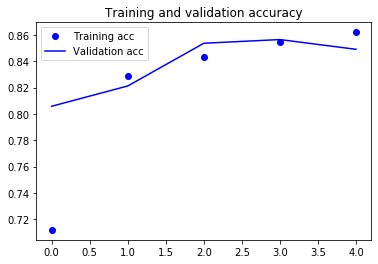

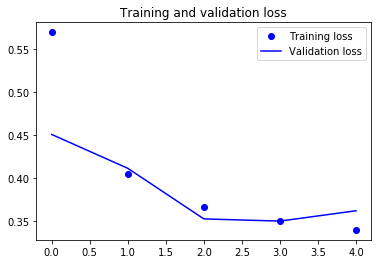

In [35]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [36]:
#验证模型
#Returns the loss value & metrics values for the model in test mode

results2 = model2.evaluate(input_test, y_test)
print(results2)

25000/25000 [==============================] - 39s 2ms/step
[0.3530502226638794, 0.8510800004005432]


## 3.IMDB电影评论分类

LSTM由于其设计的特点，非常适合用于对时序数据的建模，如文本数据。将词的表示组合成句子的表示，可以采用相加的方法，即将所有词的表示进行加和，或者取平均等方法，但是这些方法没有考虑到词语在句子中前后顺序。如句子“我不觉得他好”。“不”字是对后面“好”的否定，即该句子的情感极性是贬义。使用LSTM模型可以更好的捕捉到较长距离的依赖关系。因为LSTM通过训练过程可以学到记忆哪些信息和遗忘哪些信息。

基于Keras框架，采用LSTM实现文本分类。文本采用imdb影评分类语料，共25,000条影评，label标记为正面/负面两种评价。影评已被预处理为词下标构成的序列。方便起见，单词的下标基于它在数据集中出现的频率标定，例如整数3所编码的词为数据集中第3常出现的词。这样的组织方法使得用户可以快速完成诸如“只考虑最常出现的10,000个词，但不考虑最常出现的20个词”这样的操作。词向量没有采用预训练好的向量，训练中生成，采用的网络结构如图所示：

![image](images/14.png)

具体代码如下：

In [37]:
###################### load packages ####################
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.utils.np_utils import to_categorical


###################### load data ####################
######### 只考虑最常见的1000个词 ########
num_words = 1000

######### 导入数据 #########
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

print(x_train.shape)
print(x_train[0][:5])

print(y_train.shape)
print(y_train[0])


###################### preprocess data ####################
######## 句子长度最长设置为20 ########
max_len = 20

######## 对文本进行填充，将文本转成相同长度 ########
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

print(x_train.shape)
print(x_train[0])

######## 对label做one-hot处理 ########
num_class = 2
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

print(y_train.shape)
print(y_train[0])


###################### build network ####################
######## word dim 词向量维度 ########
word_dim = 8

######## network structure ########
model = Sequential()

#### Embedding层 ####
model.add(Embedding(input_dim=1000, output_dim=word_dim, input_length=max_len))

#### 两层LSTM，第一层，设置return_sequences参数为True ####
model.add(LSTM(256, return_sequences=True))

#### dropout ####
model.add(Dropout(0.5))

#### 两层LSTM，第二层，设置return_sequences参数为False ####
model.add(LSTM(256, return_sequences=False))

#### dropout ####
model.add(Dropout(0.5))

#### 输出层 ####
model.add(Dense(num_class, activation='softmax'))

print(model.summary())

######## optimization and train ########
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=1, validation_data=(x_test, y_test))

(25000,)
[1, 14, 22, 16, 43]
(25000,)
1
(25000, 20)
[ 65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32]
(25000, 2)
[0. 1.]
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 8)             8000      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 256)           271360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (N

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 39s 2ms/step - loss: 0.6606 - acc: 0.5933 - val_loss: 0.5991 - val_acc: 0.6843
Epoch 2/20
25000/25000 [==============================] - 39s 2ms/step - loss: 0.5493 - acc: 0.7190 - val_loss: 0.5263 - val_acc: 0.7338
Epoch 3/20
25000/25000 [==============================] - 38s 2ms/step - loss: 0.5106 - acc: 0.7458 - val_loss: 0.5208 - val_acc: 0.7374
Epoch 4/20
25000/25000 [==============================] - 41s 2ms/step - loss: 0.5016 - acc: 0.7529 - val_loss: 0.5185 - val_acc: 0.7357
Epoch 5/20
25000/25000 [==============================] - 39s 2ms/step - loss: 0.4951 - acc: 0.7559 - val_loss: 0.5163 - val_acc: 0.7380
Epoch 6/20
25000/25000 [==============================] - 39s 2ms/step - loss: 0.4942 - acc: 0.7571 - val_loss: 0.5252 - val_acc: 0.7305
Epoch 7/20
25000/25000 [==============================] - 39s 2ms/step - loss: 0.4933 - acc: 0.7563 - val_loss: 0.5194 - val_acc

# Any Questions?